# Preface

As we know that the following competition is based on predicting the future motions of the traffic agents based on the input received from the **Perception Task**. Basically this is the task of **Motion Forecasting**. Don't worry if these terms are not clear to you right now. I hope after reading this notebook, they won't be so much abstract.

This Notebook will follow the below mentioned topics sequentially and by the end, you would surely be having enough knowledge to proceed further with your approach for this scenario.

# Contents

1. [Understanding the concepts](#1)
2. [Understanding Data](#2)
3. [Sample Model structure](#3)
4. [References](#4)

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict


import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"

In [ ]:
# UTILITY FUNCTIONS

def visualize_image(ds, idx, axis=None):
    data = ds[idx]
    im = data["image"].transpose(1, 2, 0)
    im = ds.rasterizer.to_rgb(im)
    if axis:
        axis.imshow(im[::-1])
    else:
        plt.imshow(im[::-1])

def build_model(cfg: Dict) -> torch.nn.Module:
    # Backbone model
    model = resnet50(pretrained=True)
    
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    
    # Getting input channels for first layer of the model.
    num_in_channels = 3 + num_history_channels
    
    # Getting the number of targets.
    num_targets = 2*cfg["model_params"]["future_num_frames"]
    
    # Adjusting the first layer for the number of input channels.
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False
    )
    
    # Adjusting the final layer for the number of targets.
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)
    return model

def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    targets = data["target_positions"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    
    outputs = model(inputs).reshape(targets.shape).to(device)
    
    loss = torch.sqrt(criterion(outputs, targets))
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

<a id="1"></a>
# 1. Understanding the concepts 

We would not dive into the very depth of the concepts but a high level knowledge of the things would be enough to proceed in the competition. After this notebook you would have a clear view of whether you should focus in the domain of self driving or not.

Let's just get started-

- **When to say vehicle is self driving:** We can say that a vehicle is self driving when it requires minimum human intervention while driving. If a vehicle is able to take up the essential decisions of driving task such as driving along a route, stopping on encountering an obstacle (OEDR), estimating the type of movement and type objects and responding accordingly etc.

                                        
- **Ego Vehicle:** The vehicle on which self automation is to be achieved. The word **Ego** denotes a notion of **self**.


- **Traffic Agents:** Surrounding objects on the road other than the ego vehicle. These include pedestrians, other vehicles, cyclists etc.


- **Ego Localization:** Apart from estimating the position of the surroundings, it is also required that we calculate the position of ego vehicle for calculating its velocity, angular motion, acceleration etc.


- **Sensors:** Sensors are the devices that measures or detects a property of the environment or the changes in it. Basically there are two types of sensors used for self driving tasks viz **Exteroceptive** and **Proprioceptive** sensors. Let's just discuss these two sensors-
         
    - A. **Exteroceptive Sensors:** The sensors which are responsible for capturing the information of the environment around the ego vehicle. Information about the traffic agents and other static and dynamic objects are captured through these sensors.
    
    - B. **Proprioceptive Sensors:** The sensors which are responsible for ego localization or which records the properties of ego vehicle. These sensors help in determining the position, velocity, acceleration, angular motion etc of the ego vehicle.
    
    Let's just take some examples of Exteroceptive and Proprioceptive sensors. (Aa, Ba- First index of Exteroceptive and Proprioceptive sensors respectively)
    
    - Aa. **Lidars:** Lidar stands for Light Detection and Ranging. As the name suggests these sensors emit light and the time of reflection of the light from surrounding objects is used to calculate the distance of ego vehicle from those objects. 
    > Output from the Lidar(s) is used to create a "Localization map".
    
    - Ab. **Radars:** Radar stands for Radio Detection and Ranging. These sensors use radio signals to calculate the distance of ego vehicle from the surrounding objects.
    
    - Ba. **GNSS:** GNSS stands for Global Navigation Satellite System. These are used for calculating the position of any vehicle. GPS is one of the class of GNSS.
    
    - Bb. **IMU:** IMU stands for Intertial Measurment Unit. These sensors are responsible for calculating the  acceleration and velocity of the vehicle or in other words, the "longitudnal motion" of the vehicle.
  
    Other class of sensors are SONARS(A), WHEEL ODOMETRY(B) etc.


- **Lateral Control:** Lateral control corresponds to the control of vehicle over its angular motion like changing lane, taking turn etc. This motion deals with controlling the steering of the vehicle.


- **Longitudnal Control:** Longitudnal control corresponds to the control of vehicle over its velocity, acceleration, braking etc.


- **OEDR:** OEDR stands for Object and Event Detection and Response. It corresponds to the immediate actions taken by the vehicles such as applying brake on encountering a sudden obstacle or handling of overtaking by other vehicles.


- **ACC:** ACC stands for Adaptive Cruise Control. It is a system for controlling longitudnal speeds and widely used in Level-2 vehicles(see below).


- **FMEA:** FMEA stands for Failure mode and effects analysis. It is a bottom up approach to detect failures in subsystems and their impact on higher levels.


- **ODD:** ODD stands for Operational Design Domain. These are the set of conditions under which a particular system is designed to funtion.


- **Perception task:** Understanding and estimating the future of objects around the ego vehicle is referred to as perception task.


- **Motion Forecasting:** From the view of perception task, motion forecasting is the predicting of future motion of the traffic agents.

**Now that we have looked over some of the basic definitions under self driving domain, lets understand what does Level-5 mean in this competition. Basically Level-5 corresponds to the fifth level of automation. So a genuine question would be: What are the levels of automation?**

The answer is fairly simple, the increasing capability of automation offered by vehicles is being classified in different levels of automation. Let's just look at these different levels- 

- **Level-0 automation:** At this level, no automation is expected from the vehicle.


- **Level-1 automation:** This level of automation basically comes with a driver assistance in which the machine assists the drive to take actions such as taking the best route, steering or accelerating etc. As discussed above, ACC is commonly used at this level.


- **Level-2 automation:** This level of automation is slightly improved from the previous one with an addition of lateral and longitudnal controls by the vehicle. It is also known as [advance drive assistance system](https://www.synopsys.com/automotive/what-is-adas.html)  


- **Level-3 automation:** This level includes all the functionalities of level 2 with an addition that these vehicles gain the ability to sense the surrounding environment but upto a limited extent. In most cases the vehicle is automatically able to tackle the situation but in some of the cases it just alerts the driver and the driver has to take appropriate actions.


- **Level-4 automation:** This level comes gets improvement from level 3 from the perspective of sensing its surroundings better but still is limited to some edge cases. It has a limited ODD meaning that it can work in most of the cases but a handful of cases are out of reach for it. The system can handle itself if things go wrong or any type of failure occurs.


- **Level-5 automation:** This level enjoys superiority over all the levels with an unlimited ODD meaning that vehicle would be able to handle each and every possible condition. It would not need any human intervention to while driving.

Okk, so now we are having a good amount of knowledge about the terms and definitions in the self driving domain. Let us now look over the **Self Driving Stack** which is usually implemented to accomplish a complete self driving task.

A typical software stack would look something like-


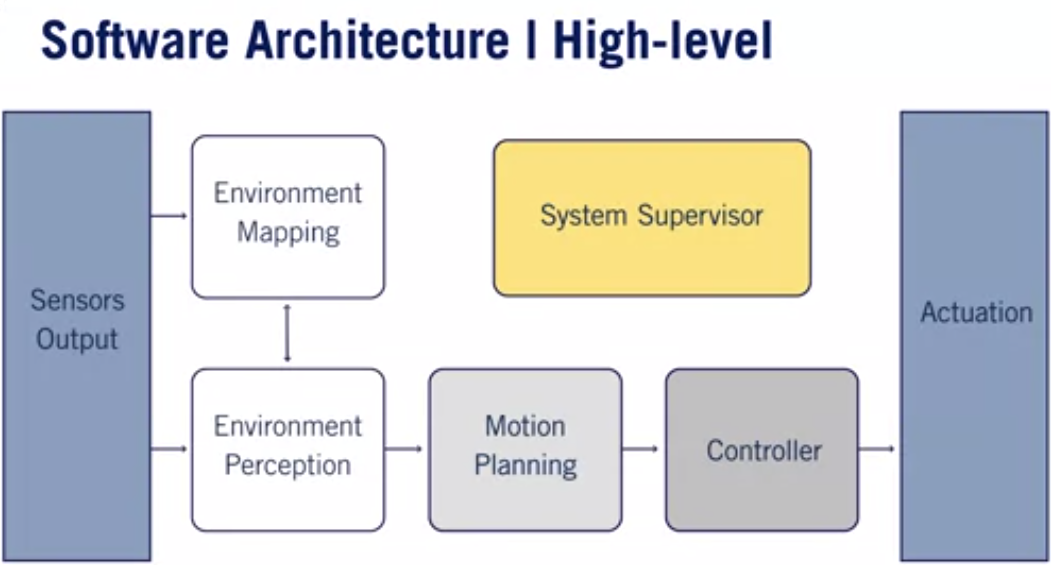
> Image from Coursera's Self Driving course [here](https://www.coursera.org/learn/intro-self-driving-cars/lecture/RQCqM/lesson-3-software-architecture).

Let's just understand these sections in short.

- **Sensors Output:** The data collected by the different sensors attached to the AV(autonomous vehicle).


- **Environmental Perception:** In this module the AV uses the sensors' output to localize itself and understand the area around it (not only the road).


- **Environmental Mapping:** This module creates a set of maps to localize the objects in the environment around ego vehicle. This module and the previous one interacts heavily to achieve a great efficiency in the perception task.


- **Motion Planning:** On the basis of outputs recieved by `Environmental Perception` and `Environmental Mapping` modules, this module plans the motion of the AV. This motion planning is categorized in three layers of abstraction-
    
    - a. **Mission Planner:** It plans the Long term goal of the AV i.e the route to the destination where it has to go.
    
    - b. **Behavioural Planner:** It plans the Short term goal of the AV i.e given certain conditions and parameters, it decides what to do for a short span of time. For example if the ego velocity is some **x** per square meters and there is a truck ahead of it then plans how to action with this given data (either change a lane or slow speed).
    
    - c. **Local Planner:** It plans the immediate actions to take by the AV and draws a planned trajectory and velocity profile that the AV should follow for a short period of time.
    
    Consider these layers as zooming into the scenerio from outside. Driving from point A to point B is handled by the `Mission Planner`, actions taken on a particular path such as whether to change the lane or whether to speed up/slow down etc are handled by the Behavioral Planner and finally the immediate actions such as planning the specific trajectory followed by AV for short period of time is handled by Local Planner.
    

- **Controller:** This module controls the AV according to the data recieved from the `Motion Planner`. It basically consists of **velocity controller** and **steering controller** which controls longitudnal and lateral motion of the AV respectively.


- **System Supervisor:** This module acts as a supervisor which manages and alerts about the failures in the system. It supervises the hardware and software components seperately.  

<a id="2"></a>
# 2. Understanding the Data

- **Please have a look [this](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/178781) discussion thread in which I've posted my analysis about the white paper explaning the structure and components of the dataset.**

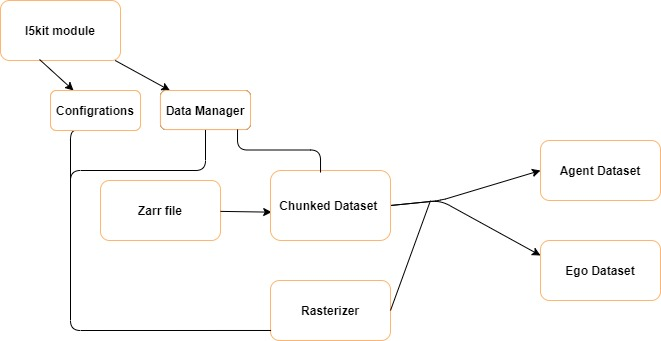

Above diagram represents that how the data exists in different forms. Let us understand the process.

We have been provided with a python package named `l5kit` which enables us to structure raw data according to the task and train a model over it.
> We can also structure the data and train the model without using `l5kit` module but that would require redundant and very hard work.

Now the `l5kit` module has functions namely "load_config_data" and "LocalDataManager" (not following the complete heirarchy). `load_config_data` basically loads the configrations needed for the dataset and to train the model and `LocalDataManager` is basically instantiated to manage different operations related to data such as creating Dataset instance or building rasterizer. At first we take the raw `zarr files` and dm (LocalDataManager instance) and build a `ChunkedDataset` which contains 4 attributes namely `scenes`, `agents`, `tl_faces`, `frames`.
> The details of these attributes are very well described in other notebooks. I will add a link to that in the reference section.

We use cfg (configration) and dm to build rasterizer using the `build_rasterizer` method also provided under `l5kit` module. The rasterizer is basically used to generate a map containing information of the ego vehicle and other traffic agents. This map could be one of the `semantic` or `aerial(satellite)`.

As such there is no image information present in the dataset until we rasterize it. The `ChunkedDataset` instance that we made previously, has information regarding both the traffic agents and ego vehicle. But the task for this competition is to identify the motion of traffic agents (for 50 frames in the future) and we need something to sample the dataset regarding traffic agents and thus we convert the `ChunkedDataset` instance into `AgentDataset` or `EgoDataset` instance which samples the data with a focus to traffic agents and ego vehicle respectively. As seen from the figure that we need both the `ChunkedDataset` instance and the `rasterizer` to generate the `AgentDataset` and `EgoDataset`.
> Note that the AgentDataset and EgoDataset when instantiated, contains the information of image (map representation of the particular frame) as now the data is being rasterized. But it contains the data in the world coordinates which we need to project onto the image subspace in order to visualize it.

We would finally use the instance of `AgentDataset` to train our model. More specifically our main feature would be the data["image"] and our target variable would be the data["target_positions"] where data is a particular element of the instance of `AgentDataset`.


Note that we can also adjust the size of image built with the rasterizer using the cfg["raster_params"]["raster_size"] which defaults to **224 x 224** in size.

**Let us now try to reach the AgentDataset or EgoDataset instance from a sample zarr file.**

In [ ]:
dm = LocalDataManager()
cfg = load_config_data("../input/lyft-config-files/agent_motion_config.yaml")
sample_zarr = dm.require("scenes/sample.zarr")
sample_chunk = ChunkedDataset(sample_zarr).open()

In [ ]:
# Let us have a look at the above discussed attributes of ChunkedDataset instance.
print(sample_chunk.scenes)
print()
print(sample_chunk.agents)
print()
print(sample_chunk.tl_faces)
print()
print(sample_chunk.frames)

In [ ]:
# Look at the cfg
cfg

Now we need basically two different type of maps viz semantic and satellite to visualize the image generated by rasterizer in different ways. For this we create two different instances of rasterizer viz `raster_sem` and `raster_sat`.  

In [ ]:
# Semantic Rasterizer
cfg["raster_params"]["map_type"] = "py_semantic"
raster_sem = build_rasterizer(cfg, dm)

# Satellite Rasterizer
cfg["raster_params"]["map_type"] = "py_satellite"
raster_sat = build_rasterizer(cfg, dm)

Now to visualize the images we need either EgoDataset or AgentDataset instance as discussed above. We would go with EgoDataset instance. We would also prepare this dataset for the two versions of rasterizer.

In [ ]:
cfg["raster_params"]["map_type"] = "py_semantic"
ego_dataset_sem = EgoDataset(cfg, sample_chunk, raster_sem)

cfg["raster_params"]["map_type"] = "py_satellite"
ego_dataset_sat = EgoDataset(cfg, sample_chunk, raster_sat)

In the similar way you could create the AgentDataset instance.

**Let us just compare the images of satellite as well as semantic map for different frames.**

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
for i in range(3):
    visualize_image(ego_dataset_sem, i+10, axis=ax[i])
    ax[i].set_title("Semantic Image")
    
    visualize_image(ego_dataset_sat, i+10, axis=ax[i+3])
    ax[i+3].set_title("Satellite Image")
    

<a id="3"></a>
# 3. Sample Model Structure

**Congratulations if you're following the tutorial from starting as now you have the knowledge of**

- self driving vehicles
- concepts related to self driving vehicles
- Different Levels of automation
- Self driving Stack
- Dataset for this competition<br>

and many more...

We can now finally talk about the model that would be used to train the data that we structured in previous sections. In the following, I would create a dummy model using the `resnet50` architecture.

## Steps of Model training

### Step.1 Declare the configrations

The configrations that we would use are already contained in the cfg variable but it is quite easier to work when you have all the parameters required in front of you. Hence we would declare a `cfg` dictionary containing the necessary configrations for model training.

PS: Declaring LocalDataManager instance also comes under this step.

In [ ]:
cfg = {
    'format_version': 4,
 
    'model_params': {'model_architecture': 'resnet50',
    'history_num_frames': 0,
    'history_step_size': 1,
    'history_delta_time': 0.1,
    'future_num_frames': 50,
    'future_step_size': 1,
    'future_delta_time': 0.1},
 
    'raster_params': {'raster_size': [224, 224],
    'pixel_size': [0.5, 0.5],
    'ego_center': [0.25, 0.5],
    'map_type': 'py_semantic',
    'satellite_map_key': 'aerial_map/aerial_map.png',
    'semantic_map_key': 'semantic_map/semantic_map.pb',
    'dataset_meta_key': 'meta.json',
    'filter_agents_threshold': 0.5},
 
    'train_data_loader': {'key': 'scenes/sample.zarr',
    'batch_size': 12,
    'shuffle': True,
    'num_workers': 16},
 
    'test_data_loader': {'key': 'scenes/test.zarr',
    'batch_size': 8,
    'shuffle': False,
    'num_workers': 8},

    'train_params': {'checkpoint_every_n_steps': 10000,
    'max_num_steps': 5,
    'eval_every_n_steps': 10000}}

>In the above code, I am using the `sample.zarr` file for training for illustration purpose as `train.zarr` is computationally expensive to process through training but we would use `train.zarr` file for training the model.

### Step 2. Prepairing the Dataset

Note that we need to predict traffic agents' future motion and thus creating AgentDataset. Moreover we have the `sample_chunk` dataset and hence we can move directly for creating the AgentDataset. 

We would also need rasterizer to create the AgentDataset instance and we can choose anyone b/w raster_sem and raster_sat.**

In [ ]:
sample_agent = AgentDataset(cfg, sample_chunk, raster_sem)

### Step 3. Instantiating and training the model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Generating Dataloader object for out sample_agent dataset
sample_config = cfg["train_data_loader"]
sample_dataloader = DataLoader(sample_agent, batch_size=sample_config["batch_size"],
                               shuffle=sample_config["shuffle"], num_workers=sample_config["num_workers"])

In [ ]:
## TRAINING LOOP
iter_train = iter(sample_dataloader)
progress = tqdm(range(cfg["train_params"]["max_num_steps"]))

for _ in progress:
    try:
        train_data = next(iter_train)
    except:
        iter_train = iter(sample_dataloader)
        train_data = next(iter_train)
    
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(train_data, model, device, criterion)
    
    # Zeroing out gradients
    optimizer.zero_grad()
    
    # Backprop
    loss.backward()
    
    # Update the weights
    optimizer.step()
    
    progress.set_description(f"Loss: {loss.item()}")

### Step 4. Inference

This step deals with computing predictions for the test dataset and preparing a submission file for it.

In [ ]:
# Preparing Test Data
test_config = cfg["test_data_loader"]
test_zarr = dm.require("scenes/test.zarr")
test_chunk  = ChunkedDataset(test_zarr).open()
test_mask  = np.load("../input/lyft-motion-prediction-autonomous-vehicles/scenes/mask.npz")["arr_0"]
test_agent = AgentDataset(cfg, test_chunk, raster_sem, agents_mask = test_mask)
test_dataloader = DataLoader(test_agent, batch_size=test_config["batch_size"], shuffle=test_config["shuffle"],
                            num_workers=test_config["num_workers"])

In [ ]:
model.eval()

future_coords = []
timestamps = []
track_ids = []

with torch.no_grad():
    iter_test = tqdm(test_dataloader)
    for data in iter_test:
        _, outputs = forward(data, model, device, criterion)
        timestamps.append(data["timestamp"])
        track_ids.append(data["track_id"])

Finally we write our predictions to a CSV file and for this also we have multi modal and single mode submission files which allow us to either ensemble the predictions or use a prediction by single model. 

We are also provided with the function `write_pred_csv` which automatically writes the predictions into the submission file.

In [ ]:
write_pred_csv("submission.csv",
              timestamps=np.concatenate(timestamps),
              track_ids=np.concatenate(track_ids),
              coords=np.concatenate(future_coords))

<a id="4"></a>

# 4. References:

- https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/178323
- https://www.kaggle.com/nxrprime/lyft-understanding-the-data-baseline-model
- https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library
- https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition


**THAT'S IT FOR THIS NOTEBOOK GUYS!!!**

**HOPE YOU LIKED MY WORK AND IF SO, PLEASE UPVOTE.**

Moreover I would also introduce a notebook for detailed model analysis using some of the dominant model architectures of the field. Till then stay tuned! Happy Coding.